In [1]:
import pandas as pd
import numpy as np
import zipfile 
import io
import os
import concurrent.futures
import time
import subprocess
import multiprocessing


## Function to unzip folder

In [5]:
# Extract the zip and save in interim
data_folder = '../data'
zip_flight_data= data_folder + '/external/itineraries_csv.zip'

extract_directory = data_folder +'/interim'

# Read the zip file
with zipfile.ZipFile(zip_flight_data, 'r') as z:
    z.extractall(extract_directory)

print(f"Extracted {zip_flight_data} to {extract_directory}")



Extracted ../data/external/itineraries_csv.zip to ../data/interim


## Function to unzip CSV and save them as 1 per airport

In [8]:
# CHAMPION FILE EXTRACTOR
def process_folder(folder):    
    df_list = []
    files = os.listdir(f"../data/interim/itineraries_csv/{folder}")
    for file in files:
        file_path = f"../data/interim/itineraries_csv/{folder}/{file}"
        if file.endswith('.zip'):
            df=pd.read_csv(file_path, compression='zip')
            df_list.append(df)
    df_list = pd.concat(df_list)
    df_list.to_csv(f"../data/interim/{folder}.csv", index=False)
    print(f"Saved {folder}.csv")
root_dir = "../data/interim/itineraries_csv"
folders = [entry.name for entry in os.scandir(root_dir) if entry.is_dir()]

# Measure execution time
start_time = time.time()

# Limit the number of threads
max_threads = 4

# Use multiprocessing.Pool to run the folder processing function in parallel
with multiprocessing.Pool(processes=max_threads) as pool:
    pool.map(process_folder, folders)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

Saved IAD.csv
Saved JFK.csv
Saved PHL.csv
Saved ORD.csv
Saved OAK.csv
Saved DTW.csv
Saved DEN.csv
Saved LAX.csv
Saved CLT.csv
Saved EWR.csv
Saved MIA.csv
Saved BOS.csv
Saved LGA.csv
Saved ATL.csv
Saved SFO.csv
Saved DFW.csv
Execution time: 56.55 seconds


In [9]:
# Remove the processed folders to save storage space
subprocess.run(f"rm -rf ../data/interim/itineraries_csv", shell=True)
subprocess.run(f"rm -rf ../data/interim/__MACOSX", shell=True)
print("Removed folders")


Removed folders


In [2]:
df = pd.read_csv('../data/interim/ATL.csv')


In [3]:
df.describe( include='all') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874069 entries, 0 to 874068
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              874069 non-null  object 
 1   searchDate                         874069 non-null  object 
 2   flightDate                         874069 non-null  object 
 3   startingAirport                    874069 non-null  object 
 4   destinationAirport                 874069 non-null  object 
 5   travelDuration                     874069 non-null  object 
 6   isBasicEconomy                     874069 non-null  bool   
 7   isRefundable                       874069 non-null  bool   
 8   isNonStop                          874069 non-null  bool   
 9   totalFare                          874069 non-null  float64
 10  totalTravelDistance                769021 non-null  float64
 11  segmentsDepartureTimeEpochSeconds  8740

## Clean up data

In [4]:
# Function to clean and convert the data
def transform_data(df):

    # Convert date columns
    date_columns = ['searchDate', 'flightDate']
    df[date_columns] = df[date_columns].apply(pd.to_datetime)

    # Convert float to numeric
    float_columns = ['totalFare','totalTravelDistance']
    for col in float_columns:
        df[col] = pd.to_numeric(df[col],errors='coerce').astype('float32')

       


    # Drop rows
    df = df.dropna(subset=['segmentsEquipmentDescription','segmentsAirlineName'])
    return df

    


In [15]:
# covert the segment data into new variables

airports= ['ATL','BOS','DEN','DFW','EWR','JFK','LAX','LGA','MIA','OAK','ORD','PHL','SFO']
# dictionary for the correct time offsets
time_offsets = {'ATL': '-04:00', 'BOS' : '-04:00' , 'DEN':'-06:00', 'DFW':'-05:00' ,'EWR':'-04:00',   'JFK': '-04:00','LAX': '-07:00', 'LGA': '-04:00', 'MIA': '-04:00', 'OAK': '-07:00', 'ORD': '-05:00', 'PHL': '-04:00', 'SFO': '-07:00'}


def process_segments(df):
    # Split the departure time
    print("Shape before processing: ", df.shape)
    df["segmentsDepartureTimeRaw_hour"] = df["segmentsDepartureTimeRaw"].str.split("|").str[0]
    airportcode = df["startingAirport"][0]
    correct_time_offset = time_offsets[airportcode]

    # filter for departure time hour that has the correct time offset
    df = df[df["segmentsDepartureTimeRaw_hour"].str[-6:] == correct_time_offset]
    print("Shape after processing departure time: ", df.shape)

    # check date difference between the  segmentsDepartureTimeRaw_hour aNd flight date and eliminate any that dont match
    df["segmentsDepartureTimeRaw_hour"] = pd.to_datetime(
        df["segmentsDepartureTimeRaw_hour"]
    ).dt.tz_localize(None)
    df = df[(df["segmentsDepartureTimeRaw_hour"] - df["flightDate"]).dt.days == 0]
    print("Shape after filtering segment departure not the same as flight date: ", df.shape)

    return df

In [16]:
df_segments = process_segments(transform_data(df))

Shape before processing:  (848482, 23)


/tmp/ipykernel_1121/2497379427.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['segmentsDepartureTimeRaw_hour'] = (df['segmentsDepartureTimeRaw'].str.split('|').str[0])


Shape after processing departure time:  (848474, 24)


/tmp/ipykernel_1121/2497379427.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['segmentsDepartureTimeRaw_hour'] = pd.to_datetime(df['segmentsDepartureTimeRaw_hour']).dt.tz_localize(None)


Shape after filtering segment departure not the same as flight date:  (848468, 24)


In [3]:
airport_timezone = pd.read_csv('../data/LOOKUP TABLE/airports_and_timezones.csv')

In [6]:
def return_timezone(airport_code):
    try:
        return airport_timezone[airport_timezone['iata'] == airport_code]['gmt_offset'].values[0]*-1
    except:
        return np.nan

def run_error_check(airport):
    df = pd.read_csv(f'../data/interim/{airport}.csv')
    print(f"Unique values in {airport}: {df['startingAirport'].unique()}")

    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"Duplicates in {airport}: {duplicates}")

    # Check for negative totalFare
    negative_fare = (df['totalFare'] < 0).sum()
    print(f"Negative totalFare in {airport}: {negative_fare}")

    # Check the values in segment Departure time raw and what values they end in
    df['segmentsDepartureTimeRaw_hour'] = (df['segmentsDepartureTimeRaw'].str.split('|').str[0])
    print(f"Departure Time time zones in {airport}:",df['segmentsDepartureTimeRaw_hour'].str[-6:].value_counts())

    # time_zone = return_timezone(airport)
    
    # df['segmentsDepartureTimeRaw_sec'] = pd.to_datetime(df['segmentsDepartureTimeEpochSeconds'].str.split('|').str[0], unit='s').dt.tz_localize('UTC').dt.tz_convert(f'Etc/GMT+{time_zone}')
    # df['segmentsDepartureTimeRaw_sec_date'] = df['segmentsDepartureTimeRaw_sec'].dt.date
    # df['flightDate'] = pd.to_datetime(df['flightDate']).dt.date
    # mismatch_dates=df[df['segmentsDepartureTimeRaw_sec_date'] - df['flightDate'] > 2]  

    # print(f"Number of mismatched dates in {airport}: ",mismatch_dates.value_counts())
    
    return 

# run_error_check('ATL')

airports= ['ATL','BOS','DEN','DFW','EWR','JFK','LAX','LGA','MIA','OAK','ORD','PHL','SFO']

# for airport in airports:
#     run_error_check(airport)

# Limit the number of threads
max_threads = 4

# Use multiprocessing.Pool to run the folder processing function in parallel
with multiprocessing.Pool(processes=max_threads) as pool:
    pool.map(run_error_check, airports)
    
    
# df = pd.read_csv('../data/interim/BOS.csv')
# mismatch_dates= error_check(transform_data(df))

Unique values in DEN: ['DEN']
Unique values in ATL: ['ATL']
Unique values in DFW: ['DFW']
Unique values in BOS: ['BOS']
Duplicates in DEN: 0
Negative totalFare in DEN: 0
Duplicates in ATL: 0
Negative totalFare in ATL: 0
Duplicates in DFW: 0
Negative totalFare in DFW: 0
Duplicates in BOS: 0
Negative totalFare in BOS: 0
Departure Time time zones in DEN: segmentsDepartureTimeRaw_hour
-06:00    770429
Name: count, dtype: int64
Departure Time time zones in ATL: segmentsDepartureTimeRaw_hour
-04:00    874061
-05:00         8
Name: count, dtype: int64
Departure Time time zones in DFW: segmentsDepartureTimeRaw_hour
-05:00    896592
-04:00         4
Name: count, dtype: int64
Departure Time time zones in BOS: segmentsDepartureTimeRaw_hour
-04:00    989175
Name: count, dtype: int64
Unique values in JFK: ['JFK']
Unique values in EWR: ['EWR']
Duplicates in JFK: 0
Negative totalFare in JFK: 0
Duplicates in EWR: 0
Negative totalFare in EWR: 0
Departure Time time zones in JFK: segmentsDepartureTimeRaw

In [ ]:
eRROR IN 
DFW AND atl OAK MIA

In [47]:
df_clean = transform_data(df)

In [27]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 848482 entries, 0 to 874068
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   legId                              848482 non-null  object        
 1   searchDate                         848482 non-null  datetime64[ns]
 2   flightDate                         848482 non-null  datetime64[ns]
 3   startingAirport                    848482 non-null  object        
 4   destinationAirport                 848482 non-null  object        
 5   travelDuration                     848482 non-null  object        
 6   isBasicEconomy                     848482 non-null  bool          
 7   isRefundable                       848482 non-null  bool          
 8   isNonStop                          848482 non-null  bool          
 9   totalFare                          848482 non-null  float32       
 10  totalTravelDistance      

## Run some graphs to visualise the data

In [64]:
# function to plot the data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




# Function to plot the data
def plot_data(df):
    # Plot the total fare distribution
    sns.histplot(df['totalFare'], kde=True)
    plt.title('Total Fare Distribution')
    plt.show()

    # Plot the total travel distance distribution
    sns.histplot(df['totalTravelDistance'], kde=True)
    plt.title('Total Travel Distance Distribution')
    plt.show()

    # #plot the segmentsAirlineCode, destinationAirport, segmentCabinCode in a facet grid
    # sns.catplot(data=df, kind='count', x='segmentsAirlineCode', col='destinationAirport', row='segmentsCabinCode')
    # plt.show()

    # Plot the total fare vs total travel distance
    sns.scatterplot(data=df, x='totalFare', y='totalTravelDistance')
    plt.title('Total Fare vs Total Travel Distance')
    plt.show()

    # Plot the destination city vs total fare
    sns.catplot(data=df,kind='violin', x='destinationAirport', y='totalFare') 

    # Plot the arrival time vs total fare
    sns.catplot(data=df,kind='violin', x='segmentsDepartureTimeRaw_hour', y='totalFare')

    # Plot the distributions of total fare by isNonStop, isRefundable, and isBasicEconomy
    sns.catplot(data=df,kind='violin', x='isNonStop', y='totalFare')
    sns.catplot(data=df,kind='violin', x='isRefundable', y='totalFare')
    sns.catplot(data=df,kind='violin', x='isBasicEconomy', y='totalFare')

    plt.show()





In [266]:
# Function to parse the segment time
def parse_segment_time(df):
    # df['segmentsDepartureTimeRaw_hour'] = df['segmentsDepartureTimeRaw'].string() #pd.to_datetime   .str[0]).dt.hour
    df['segmentsDepartureTimeRaw_hour'] = (df['segmentsDepartureTimeRaw'].str.split('|').str[0]) # pd.to_datetime  .dt.hour ,errors='coerce'
    df['segmentsDepartureTimeRaw_sec']= pd.to_datetime(df['segmentsDepartureTimeEpochSeconds'].str.split('|').str[0],unit='s')

    return df
df_clean_test = parse_segment_time(df)
filtered_df = df_clean_test[~df_clean_test['segmentsDepartureTimeRaw_hour'].str.endswith('-04:00', na=False)]

/tmp/ipykernel_1177/2460459236.py:5: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['segmentsDepartureTimeRaw_sec']= pd.to_datetime(df['segmentsDepartureTimeEpochSeconds'].str.split('|').str[0],unit='s')


In [230]:

# Function to parse the segment time
def parse_segment_time(df):
    # df['segmentsDepartureTimeRaw_hour'] = df['segmentsDepartureTimeRaw'].string() #pd.to_datetime   .str[0]).dt.hour
    df['segmentsDepartureTimeRaw_hour'] = pd.to_datetime(df['segmentsDepartureTimeRaw'].str.split('|').str[0]) #   .dt.hour ,errors='coerce'

    return df

df_clean_test = parse_segment_time(df_clean[434378:434380])

df_clean_test['segmentsDepartureTimeRaw_hour'].dt.hour

print(df_clean_test['segmentsDepartureTimeRaw_hour'].dtype)

df_clean_error=df_clean[['segmentsDepartureTimeRaw','segmentsDepartureTimeRaw_hour']]

# df['segmentsDepartureTimeRaw_hour_new'] = df['segmentsDepartureTimeRaw_hour'].dt.hour

# df_clean_test[['segmentsDepartureTimeRaw','segmentsDepartureTimeRaw_hour']]


/tmp/ipykernel_1177/1325915397.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['segmentsDepartureTimeRaw_hour'] = pd.to_datetime(df['segmentsDepartureTimeRaw'].str.split('|').str[0]) #   .dt.hour ,errors='coerce'
/tmp/ipykernel_1177/1325915397.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['segmentsDepartureTimeRaw_hour'] = pd.to_datetime(df['segmentsDepartureTimeRaw'].str.split('|').str[0]) #   .dt.hour ,errors='coerce'


AttributeError: Can only use .dt accessor with datetimelike values

datetime64[ns, UTC-04:00]


In [113]:
# filter values that are not datetime type
df_clean_test_filtered = df_clean_test[df_clean_test['segmentsDepartureTimeRaw_hour'].isnull()]

df_clean_test_filtered[['segmentsDepartureTimeRaw','segmentsDepartureTimeRaw_hour']]


,segmentsDepartureTimeRaw,segmentsDepartureTimeRaw_hour


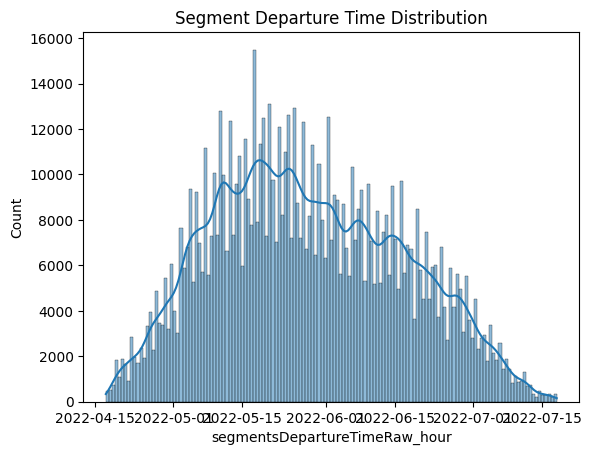

In [77]:
# visualise segment departure time
sns.histplot(df_clean_test['segmentsDepartureTimeRaw_hour'], kde=True)
plt.title('Segment Departure Time Distribution')
plt.show()


In [66]:
parse_segment_time(df_clean)
plot_data(df_clean)

/tmp/ipykernel_1177/2902269671.py:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['segmentsDepartureTimeRaw_hour'] = pd.to_datetime(df['segmentsDepartureTimeRaw'].str.split('|').str[0]).dt.hour #   .dt.hour


AttributeError: Can only use .dt accessor with datetimelike values

In [29]:
# Top desitations out of ATL
top_destinations = df_clean['destinationAirport'].value_counts()


## Merge into one master
